In [1]:
# At the beginning of your script or notebook
# %load_ext autoreload
# %autoreload 2

import os
import random
from IPython.display import HTML, display

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Third-party library imports
import torch
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split

# Local imports
from src import *
from src.probing import *
from src.visualization import _combine_html_contents, _light_mode

probes_folder = "./probe_weights"

In [2]:
model_type = "llama3"

if model_type == "llama3":
    encoder = EleutherSparseAutoencoder.load_llama3_sae(12, instruct=True)
    jailbreaks_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks")
elif model_type == "gemma2":
    encoder = DeepmindSparseAutoencoder.load_gemma2_sae(0, 11)
    jailbreak_dataset = load_dataset("Mechanistic-Anomaly-Detection/gemma2-jailbreaks")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def sample_examples_from_datasets(
    datasets, proportions, total_examples=3000, only_prompts=False
):
    # This function samples examples from multiple datasets, ensuring that the final list has the desired proportions
    # of examples from each dataset. The final list is shuffled.

    # Ensure the proportions sum to 1
    if len(datasets) != len(proportions):
        raise ValueError("Number of datasets must match number of proportions")

    if abs(sum(proportions) - 1) > 1e-6:
        raise ValueError("Proportions must sum to 1")

    examples = []
    np.random.seed(42)
    for dataset, proportion in zip(datasets, proportions):
        n_samples = int(total_examples * proportion)

        # Ensure we don't try to sample more examples than available
        sampled_indices = np.random.choice(len(dataset), size=n_samples, replace=True)
        sampled = dataset.select(sampled_indices)

        if only_prompts:
            examples.extend([item["prompt"] for item in sampled])
        else:
            examples.extend(
                [f"{item['prompt']} {item['completion']}" for item in sampled]
            )

    # Shuffle the final list to mix examples from different datasets
    random.Random(42).shuffle(examples)

    return examples


forget_examples_train = sample_examples_from_datasets(
    [jailbreaks_dataset["circuit_breakers_train"]], [1.0]
)

retain_examples_train = sample_examples_from_datasets(
    [jailbreaks_dataset["xstest"], jailbreaks_dataset["benign_instructions_train"]],
    [0.15, 0.85],
)

# Also get examples with just the prompts
forget_examples_train_prompts = sample_examples_from_datasets(
    [jailbreaks_dataset["circuit_breakers_train"]], [1.0], only_prompts=True
)

retain_examples_train_prompts = sample_examples_from_datasets(
    [jailbreaks_dataset["xstest"], jailbreaks_dataset["benign_instructions_train"]],
    [0.15, 0.85],
    only_prompts=True,
)

### Train Probes

In [4]:
file_name = os.path.join(probes_folder, f"{model_type}_linear_probes.pt")

if os.path.exists(file_name):
    linear_probes = load_probes(file_name)
else:
    linear_probes = train_linear_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        only_return_on_tokens_between=[78191, 128009],
    )
    save_probes(linear_probes, file_name)

/nas/ucb/abhay/sae_experiments/src/probing.py:507: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(load_path)


In [5]:
file_name = os.path.join(probes_folder, f"{model_type}_mlp_probes.pt")

if os.path.exists(file_name):
    mlp_probes = load_probes(file_name)
else:
    mlp_probes = train_nonlinear_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        d_mlp=64,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(mlp_probes, file_name)

In [6]:
file_name = os.path.join(probes_folder, f"{model_type}_attention_probes.pt")

if os.path.exists(file_name):
    attention_probes = load_probes(file_name)
else:
    attention_probes = train_attention_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        d_proj=64,
        nhead=8,
        sliding_window=16,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(attention_probes, file_name)

In [7]:
file_name = os.path.join(probes_folder, f"{model_type}_mean_diff_probes.pt")

if os.path.exists(file_name):
    mean_diff_probes = load_probes(file_name)
else:
    # Compute the steering vectors
    results = compute_steering_vector(
        encoder=encoder,
        positive_examples=forget_examples_train_prompts[:500],
        negative_examples=retain_examples_train_prompts[:500],
        layers=[4, 8, 10, 12, 16, 20, 24],
        position_aggregation="last",
        method="mean_diff",
    )

    # Construct the probes and finetune for callibration
    mean_diff_probes = {
        layer: DirectionalProbe(results[layer]["steering_vector"]) for layer in results
    }
    train_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        create_probe_fn=None,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        pretrained_probes=mean_diff_probes,
    )

    save_probes(mean_diff_probes, file_name)

### Generate Evaluation Plots

In [8]:
annotations_folder_name = os.path.join(
    probes_folder, "llama3_linear_probes_annotation_dataset.json"
)
if os.path.exists(annotations_folder_name):
    with open(annotations_folder_name, "r") as f:
        linear_scores_dict = json.load(f)
else:
    linear_scores_dict = get_annotated_dataset(
        linear_probes,
        encoder,
        jailbreaks_dataset,
        [
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "benign_instructions_test",
            "circuit_breakers_test",
            "or_bench_test",
            "mt_bench",
            "wildchat",
        ],
        max_length=8192,
        batch_size=16,
    )
    with open(annotations_folder_name, "w") as f:
        json.dump(linear_scores_dict, f)


annotations_folder_name = os.path.join(
    probes_folder, "llama3_mlp_probes_annotation_dataset.json"
)
if os.path.exists(annotations_folder_name):
    with open(annotations_folder_name, "r") as f:
        mlp_scores_dict = json.load(f)
else:
    mlp_scores_dict = get_annotated_dataset(
        mlp_probes,
        encoder,
        jailbreaks_dataset,
        [
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "benign_instructions_test",
            "circuit_breakers_test",
            "or_bench_test",
            "mt_bench",
            "wildchat",
        ],
        max_length=8192,
        batch_size=16,
    )
    with open(annotations_folder_name, "w") as f:
        json.dump(mlp_scores_dict, f)


annotations_folder_name = os.path.join(
    probes_folder, "llama3_attention_probes_annotation_dataset.json"
)
if os.path.exists(annotations_folder_name):
    with open(annotations_folder_name, "r") as f:
        attention_scores_dict = json.load(f)
else:
    attention_scores_dict = get_annotated_dataset(
        attention_probes,
        encoder,
        jailbreaks_dataset,
        [
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "benign_instructions_test",
            "circuit_breakers_test",
            "or_bench_test",
            "mt_bench",
            "wildchat",
        ],
        max_length=8192,
        batch_size=16,
    )
    with open(annotations_folder_name, "w") as f:
        json.dump(attention_scores_dict, f)


annotations_folder_name = os.path.join(
    probes_folder, "llama3_mean_diff_probes_annotation_dataset.json"
)
if os.path.exists(annotations_folder_name):
    with open(annotations_folder_name, "r") as f:
        mean_diff_scores_dict = json.load(f)
else:
    mean_diff_scores_dict = get_annotated_dataset(
        mean_diff_probes,
        encoder,
        jailbreaks_dataset,
        [
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "benign_instructions_test",
            "circuit_breakers_test",
            "or_bench_test",
            "mt_bench",
            "wildchat",
        ],
        max_length=8192,
        batch_size=16,
    )
    with open(annotations_folder_name, "w") as f:
        json.dump(mean_diff_scores_dict, f)

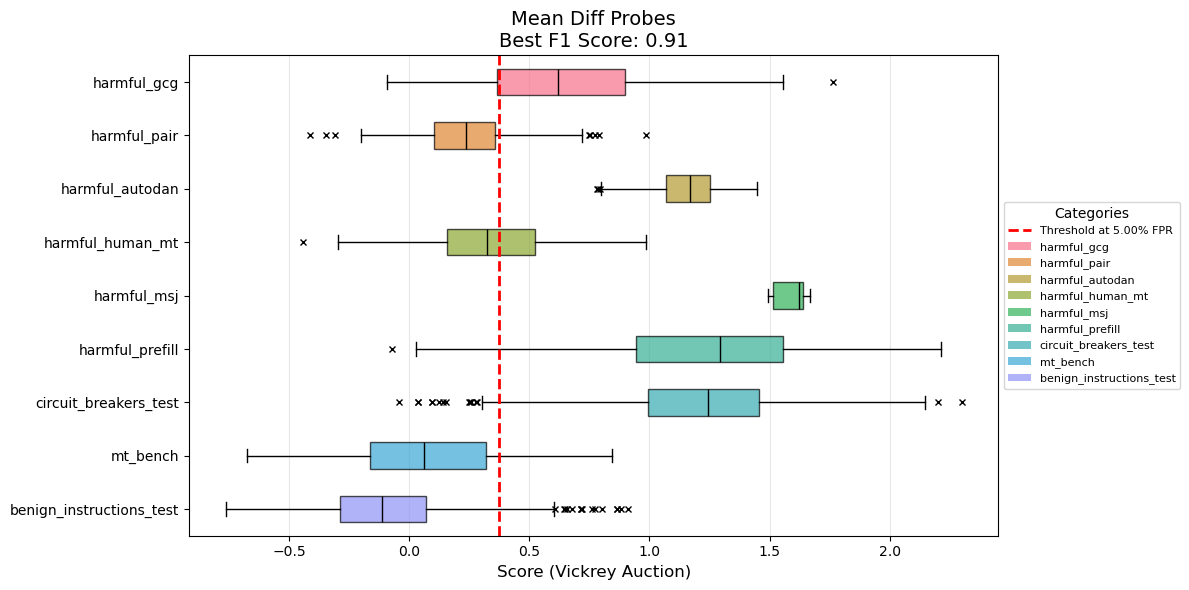

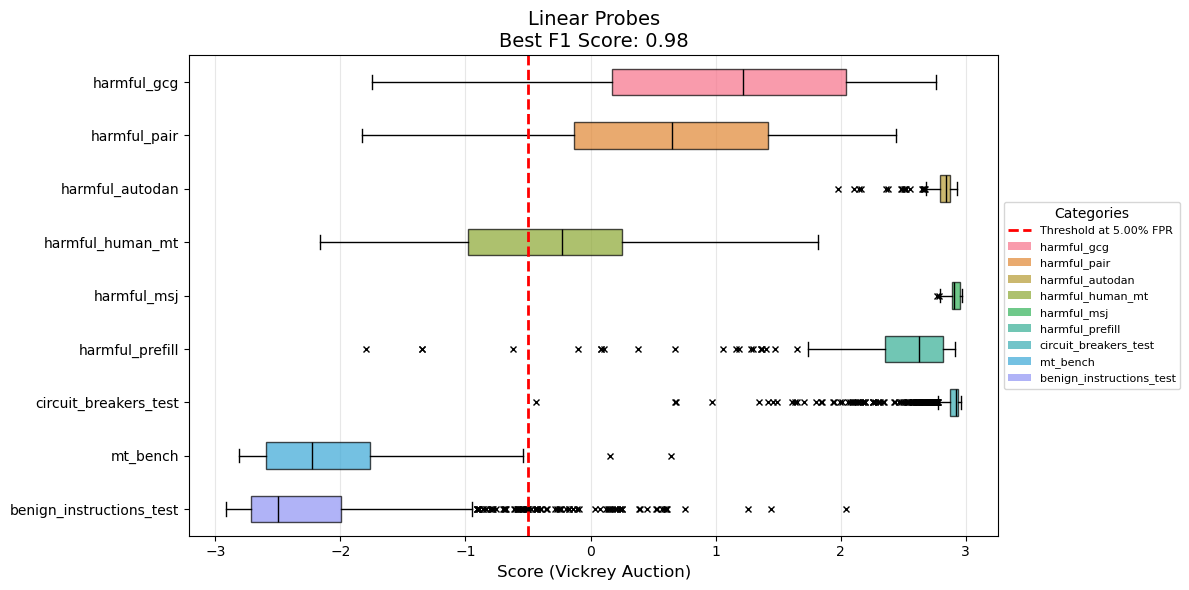

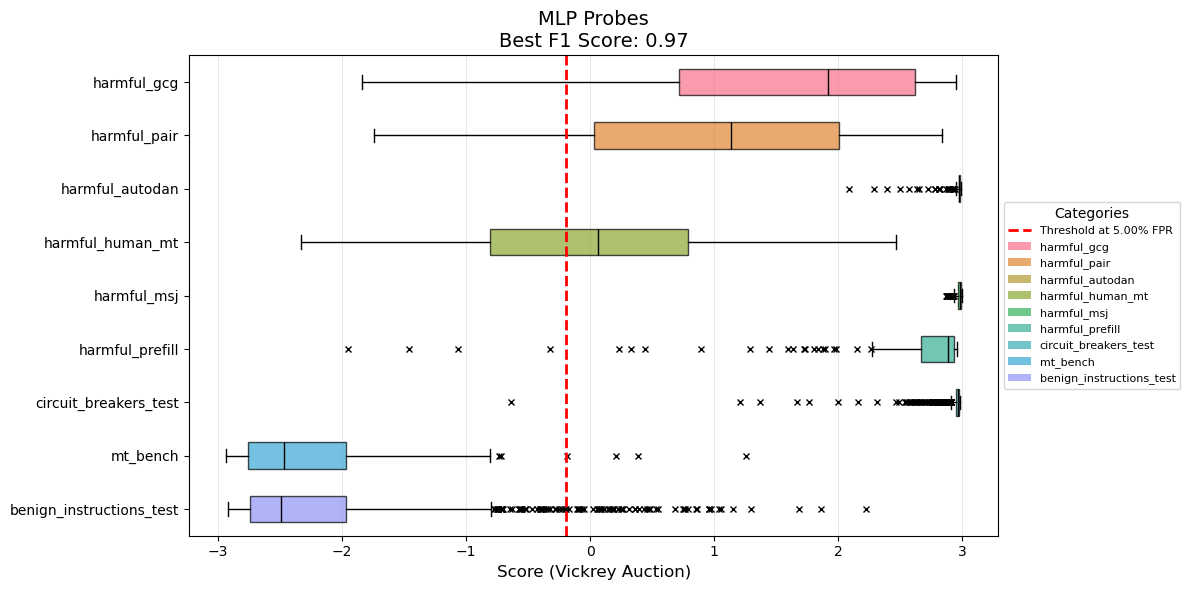

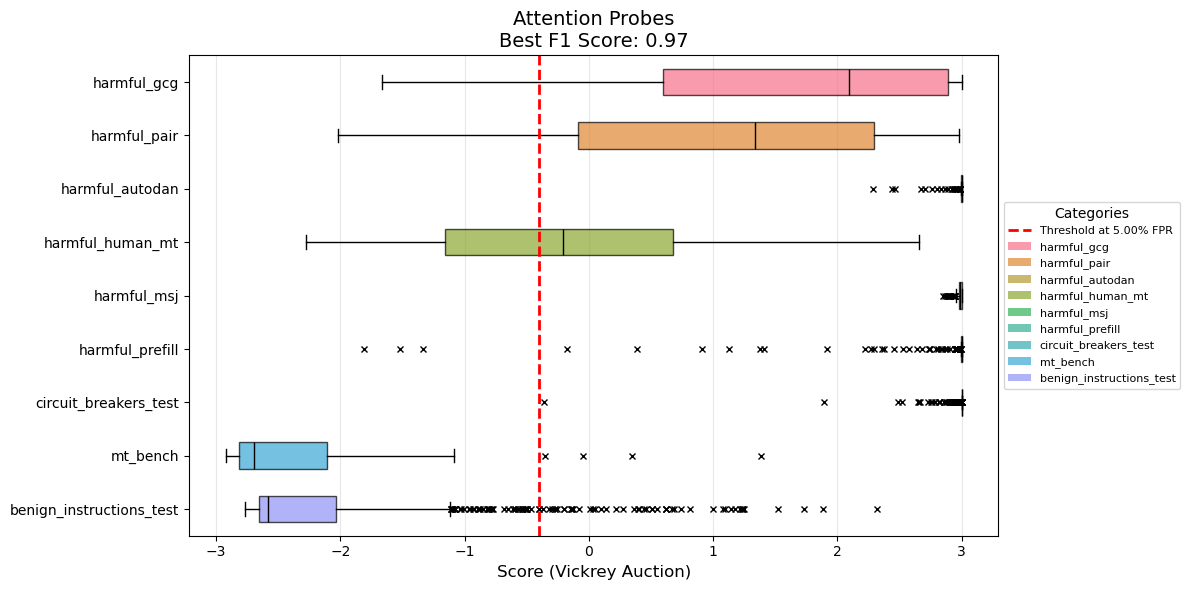

In [9]:
mean_diff_data, mean_diff_labels, mean_diff_threshold, mean_diff_f1_score = (
    generate_score_plots(
        all_split_scores=mean_diff_scores_dict,
        positive_splits=[
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "circuit_breakers_test",
        ],
        negative_splits=[
            "mt_bench",
        ],  # "or_bench_test", "wildchat"],
        heldout_splits=["benign_instructions_test"],
        layers=[4, 8, 12, 16, 20],
        cross_token_aggregation="mean",
        cross_layer_aggregation="vickrey",
        title="Mean Diff Probes",
    )
)

linear_data, linear_labels, linear_threshold, linear_f1_score = generate_score_plots(
    all_split_scores=linear_scores_dict,
    positive_splits=[
        "harmful_gcg",
        "harmful_pair",
        "harmful_autodan",
        "harmful_human_mt",
        "harmful_msj",
        "harmful_prefill",
        "circuit_breakers_test",
    ],
    negative_splits=[
        "mt_bench",
    ],  # "or_bench_test", "wildchat"],
    heldout_splits=["benign_instructions_test"],
    layers=[4, 8, 12, 16, 20],
    cross_token_aggregation="mean",
    cross_layer_aggregation="vickrey",
    title="Linear Probes",
)

mlp_data, mlp_labels, mlp_threshold, mlp_f1_score = generate_score_plots(
    all_split_scores=mlp_scores_dict,
    positive_splits=[
        "harmful_gcg",
        "harmful_pair",
        "harmful_autodan",
        "harmful_human_mt",
        "harmful_msj",
        "harmful_prefill",
        "circuit_breakers_test",
    ],
    negative_splits=[
        "mt_bench",
    ],  # "or_bench_test", "wildchat"],
    heldout_splits=["benign_instructions_test"],
    layers=[4, 8, 12, 16, 20],
    cross_token_aggregation="mean",
    cross_layer_aggregation="vickrey",
    title="MLP Probes",
)

attention_data, attention_labels, attention_threshold, attention_f1_score = (
    generate_score_plots(
        all_split_scores=attention_scores_dict,
        positive_splits=[
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "circuit_breakers_test",
        ],
        negative_splits=[
            "mt_bench",
        ],  # "or_bench_test", "wildchat"],
        heldout_splits=["benign_instructions_test"],
        layers=[4, 8, 12, 16, 20],
        cross_token_aggregation="mean",
        cross_layer_aggregation="vickrey",
        title="Attention Probes",
    )
)